Use shift-enter to execute a code block and move to the next one.

In [1]:
# 2.1 Import libraries.
import math
import os
from six.moves import xrange  # pylint: disable=redefined-builtin
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# 2.2 Define some constants.
# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 10

# The MNIST images are always 28x28 pixels.
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

# Batch size. Must be evenly dividable by dataset sizes.
BATCH_SIZE = 100
EVAL_BATCH_SIZE = 1

# Number of units in hidden layers.
HIDDEN1_UNITS = 128
HIDDEN2_UNITS = 32

# Maximum number of training steps.
MAX_STEPS = 2000

# Directory to put the training data.
TRAIN_DIR="/tmp/mnist"

In [3]:
# 2.3 Get input data: get the sets of images and labels for training, validation, and
# test on MNIST.
data_sets = read_data_sets(TRAIN_DIR, False)

Extracting /tmp/mnist\train-images-idx3-ubyte.gz
Extracting /tmp/mnist\train-labels-idx1-ubyte.gz
Extracting /tmp/mnist\t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist\t10k-labels-idx1-ubyte.gz


In [4]:
# 2.4 Build inference graph.
def mnist_inference(images, hidden1_units, hidden2_units):
    """Build the MNIST model up to where it may be used for inference.
    Args:
        images: Images placeholder.
        hidden1_units: Size of the first hidden layer.
        hidden2_units: Size of the second hidden layer.
    Returns:
        logits: Output tensor with the computed logits.
    """
    # Hidden 1
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal([IMAGE_PIXELS, hidden1_units],
                                stddev=1.0 / math.sqrt(float(IMAGE_PIXELS))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden1_units]),
                             name='biases')
        hidden1 = tf.nn.relu(tf.matmul(images, weights) + biases)
    # Hidden 2
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
            tf.truncated_normal([hidden1_units, hidden2_units],
                                stddev=1.0 / math.sqrt(float(hidden1_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden2_units]),
                             name='biases')
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
    # Linear
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal([hidden2_units, NUM_CLASSES],
                                stddev=1.0 / math.sqrt(float(hidden2_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([NUM_CLASSES]),
                             name='biases')
        logits = tf.matmul(hidden2, weights) + biases

    # Uncomment the following line to see what we have constructed.
    tf.train.write_graph(tf.get_default_graph().as_graph_def(),
                         "/tmp", "inference.pbtxt", as_text=True)
    return logits

In [5]:
# 2.5 Build training graph.
def mnist_training(logits, labels, learning_rate):
    """Build the training graph.

    Args:
        logits: Logits tensor, float - [BATCH_SIZE, NUM_CLASSES].
        labels: Labels tensor, int32 - [BATCH_SIZE], with values in the
          range [0, NUM_CLASSES).
        learning_rate: The learning rate to use for gradient descent.
    Returns:
        train_op: The Op for training.
        loss: The Op for calculating loss.
    """
    # Create an operation that calculates loss.
    labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits = logits, labels = labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # Create a variable to track the global step.
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # Use the optimizer to apply the gradients that minimize the loss
    # (and also increment the global step counter) as a single training step.
    train_op = optimizer.minimize(loss, global_step=global_step)

    # Uncomment the following line to see what we have constructed.
    tf.train.write_graph(tf.get_default_graph().as_graph_def(),
                         "/tmp", "train.pbtxt", as_text=True)

    return train_op, loss

In [6]:
# 2.6 Build the complete graph for feeding inputs, training, and saving checkpoints.
mnist_graph = tf.Graph()
with mnist_graph.as_default():
    # Generate placeholders for the images and labels.
    images_placeholder = tf.placeholder(tf.float32)                                       
    labels_placeholder = tf.placeholder(tf.int32)
    tf.add_to_collection("images", images_placeholder)  # Remember this Op.
    tf.add_to_collection("labels", labels_placeholder)  # Remember this Op.

    # Build a Graph that computes predictions from the inference model.
    logits = mnist_inference(images_placeholder,
                             HIDDEN1_UNITS,
                             HIDDEN2_UNITS)
    tf.add_to_collection("logits", logits)  # Remember this Op.

    # Add to the Graph the Ops that calculate and apply gradients.
    train_op, loss = mnist_training(logits, labels_placeholder, 0.01)

    # Add the variable initializer Op.
    init = tf.global_variables_initializer()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()
    
    # Uncomment the following line to see what we have constructed.
    tf.train.write_graph(tf.get_default_graph().as_graph_def(),
                         "/tmp", "complete.pbtxt", as_text=True)

Step 0: loss = 2.30
Step 1000: loss = 0.58


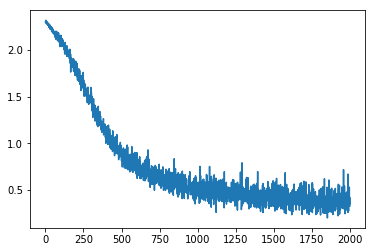

In [7]:
# 2.7 Run training for MAX_STEPS and save checkpoint at the end.
with tf.Session(graph=mnist_graph) as sess:
    # Run the Op to initialize the variables.
    sess.run(init)

    # Start the training loop.
    losses = []
    for step in xrange(MAX_STEPS):
        # Read a batch of images and labels.
        images_feed, labels_feed = data_sets.train.next_batch(BATCH_SIZE)

        # Run one step of the model.  The return values are the activations
        # from the `train_op` (which is discarded) and the `loss` Op.  To
        # inspect the values of your Ops or variables, you may include them
        # in the list passed to sess.run() and the value tensors will be
        # returned in the tuple from the call.
        _, loss_value = sess.run([train_op, loss],
                                 feed_dict={images_placeholder: images_feed,
                                            labels_placeholder: labels_feed})

        losses.append(loss_value)
        # Print out loss value.        
        if step % 1000 == 0:
            print('Step %d: loss = %.2f' % (step, loss_value))
    import matplotlib.pyplot as plt
    plt.plot(losses)
    # Write a checkpoint.
    checkpoint_file = os.path.join(TRAIN_DIR, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=step)

INFO:tensorflow:Restoring parameters from /tmp/mnist\checkpoint-1999
Ground truth: 2
Prediction: 2


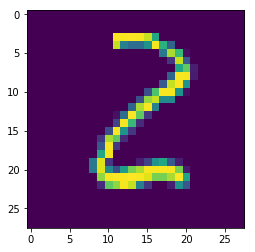

In [8]:
# 2.8 Run evaluation based on the saved checkpoint.
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(TRAIN_DIR, "checkpoint-1999.meta"))
    saver.restore(
        sess, os.path.join(TRAIN_DIR, "checkpoint-1999"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    
    # Run evaluation.
    images_feed, labels_feed = data_sets.validation.next_batch(EVAL_BATCH_SIZE)
    imgplot = plt.imshow(np.reshape(images_feed, (28, 28)))
    prediction = sess.run(eval_op,
                          feed_dict={images_placeholder: images_feed,
                                     labels_placeholder: labels_feed})
    print("Ground truth: %d\nPrediction: %d" % (labels_feed, prediction.indices[0][0]))

<p>Back to [1_linear_regression_model.ipynb](1_linear_regression_model.ipynb).</p>
<p>Next to [Bonus Lab](extras/extras_0_deepdream.ipynb).</p>